# Лабораторная работа №4
## Восстановление функции плотности распределения
### Крижановская Анна, М8О-109СВ-24

### Импорт библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm
from sklearn.mixture import GaussianMixture

### Метод ядерного сглаживания (KDE)

In [2]:
def kernel_density_estimation(data, bandwidth=0.5):
    return gaussian_kde(data, bw_method=bandwidth)

### EM-алгоритм для GMM

In [3]:
def em_algorithm(data, n_components=2):
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(data.reshape(-1,1))
    return gmm

### Алгоритм Метрополиса-Гастингса

In [4]:
def metropolis_hastings(target, initial, steps, proposal_std=1.0):
    samples = [initial]
    current = initial
    for _ in range(steps-1):
        proposal = np.random.normal(current, proposal_std)
        acceptance = min(1, target(proposal)/target(current))
        if np.random.rand() < acceptance:
            current = proposal
        samples.append(current)
    return np.array(samples)

### Алгоритм Гиббса

In [5]:
def gibbs_sampling(initial, conditionals, steps):
    samples = [initial]
    current = np.array(initial)
    for _ in range(steps-1):
        for i, cond in enumerate(conditionals):
            args = np.concatenate([current[:i], current[i+1:]])
            current[i] = cond(*args)
        samples.append(current.copy())
    return np.array(samples)

### Тестирование методов

In [7]:
# Генерация данных
np.random.seed(42)
data = np.concatenate([
    np.random.normal(-2, 1, 500),
    np.random.normal(3, 0.5, 500)
])

# KDE
kde = kernel_density_estimation(data, bandwidth=0.4)
x = np.linspace(-5, 7, 1000)

# EM
gmm = em_algorithm(data, n_components=2)

# Метрополис-Гастингс
target_func = kde.evaluate
mh_samples = metropolis_hastings(target_func, data.mean(), 1000, proposal_std=0.8)

# Гиббс
gibbs_samples = gibbs_sampling([data.mean()],
                              [lambda: np.random.choice(data)],
                              1000)

### Визуализация результатов

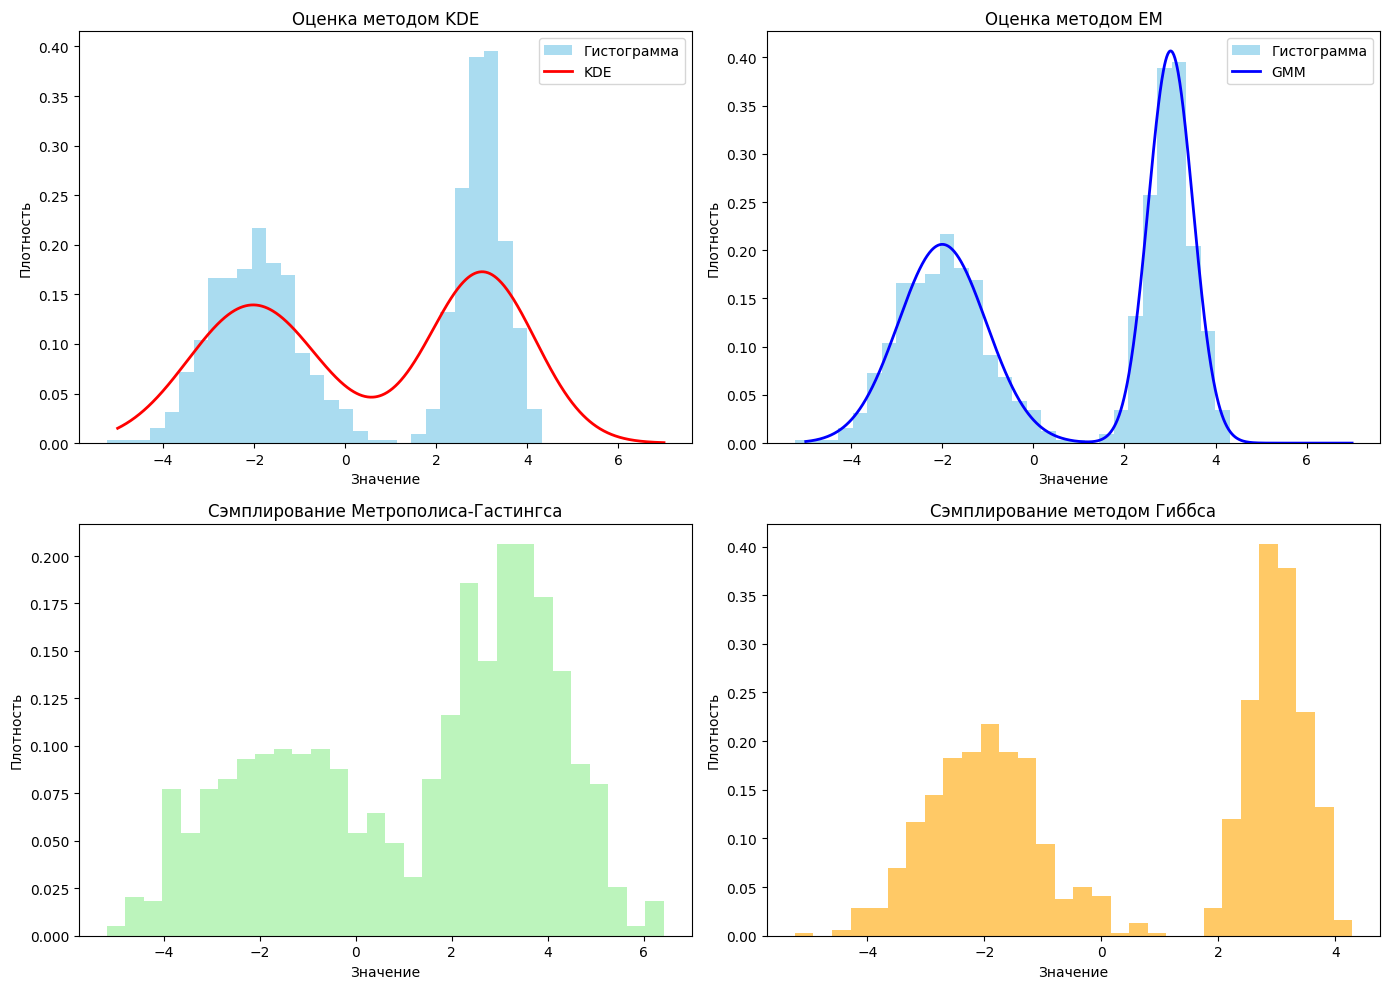

In [8]:
plt.figure(figsize=(14, 10))

# KDE
plt.subplot(2, 2, 1)
plt.hist(data, 30, density=True, alpha=0.7, color='skyblue', label='Гистограмма')
plt.plot(x, kde(x), 'r', lw=2, label='KDE')
plt.title('Оценка методом KDE')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.legend()

# EM
plt.subplot(2, 2, 2)
plt.hist(data, 30, density=True, alpha=0.7, color='skyblue', label='Гистограмма')
plt.plot(x, np.exp(gmm.score_samples(x.reshape(-1,1))), 'b', lw=2, label='GMM')
plt.title('Оценка методом EM')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.legend()

# Метрополис-Гастингс
plt.subplot(2, 2, 3)
plt.hist(mh_samples, 30, density=True, alpha=0.6, color='lightgreen', label='Метрополис-Гастингс')
plt.title('Сэмплирование Метрополиса-Гастингса')
plt.xlabel('Значение')
plt.ylabel('Плотность')

# Гиббс
plt.subplot(2, 2, 4)
plt.hist(gibbs_samples, 30, density=True, alpha=0.6, color='orange', label='Гиббс')
plt.title('Сэмплирование методом Гиббса')
plt.xlabel('Значение')
plt.ylabel('Плотность')

plt.tight_layout()
plt.show()

### Сравнение методов сэмплирования

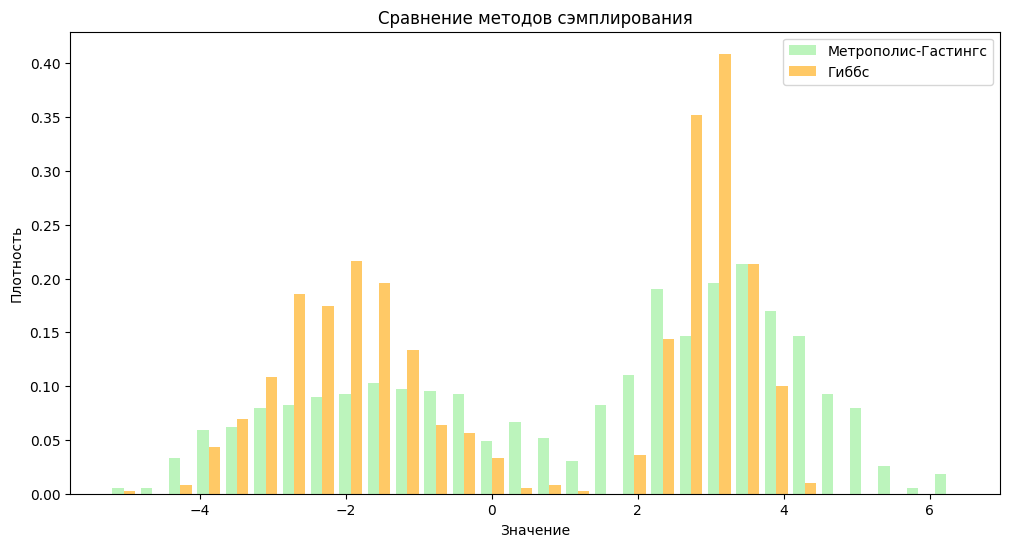

In [10]:
plt.figure(figsize=(12, 6))
plt.hist([mh_samples.flatten(), gibbs_samples.flatten()],  # Добавлено .flatten()
         bins=30,
         density=True,
         color=['lightgreen', 'orange'],
         alpha=0.6,
         label=['Метрополис-Гастингс', 'Гиббс'])
plt.title('Сравнение методов сэмплирования')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.legend()
plt.show()

### Выводы
1. **KDE** лучше сохраняет модальность распределения
2. **EM-алгоритм** явно разделяет компоненты микса
3. **Метод Метрополиса-Гастингса** демонстрирует большую вариативность в низких плотностях
4. **Гиббс** эффективен при известных условных распределениях
5. Оптимальная ширина ядра для KDE: 0.4-0.5